# MERRA2 to monthly climatologies of Tmin and Tmax
This scripts reads the MERRA2 files and generates the monthly climaoltogical files of Tmin and Tmax to be read by LDT.
Improvements for the future:
* Add an option to do it for local time. Follow UTC rules from LIS. For now, the full MERRA2 file is read (UTC0). Note that this will be hard since two files will need to be openned.
* ERA5 could be added

In [1]:
import numpy as np
import xarray as xr
import glob, os
from tqdm import tqdm

### Prep environment

In [8]:
# start and end to compte clim
ystart = 2005
yend = 2024 # this year is included

years = np.arange(ystart,yend+1)

# use lowest level model (True --> 10 m, False --> 2 m temperature)
lml = False

In [11]:
# define which files/variables to use if lml True/False
if lml:
    file_pattern = 'tavg1_2d_flx_Nx'
    T_var = 'TLML'
    out_name = 'MERRA2_LML'
else:
    file_pattern = 'tavg1_2d_slv_Nx'
    T_var = 'T2M'
    out_name = 'MERRA2'

# Define the output directory
output_dir = f'/staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/{out_name}_{ystart}-{yend}'


# List files to be read
l_files = []
for i, year in enumerate(years):
    if year > 1979 and year <= 1991:
        prefix = 'MERRA2_100'
    elif year >= 1992 and year <= 2000:
        prefix = 'MERRA2_200'
    elif year >= 2001 and year <= 2010:
        prefix = 'MERRA2_300'
    elif year >= 2011:
        prefix = 'MERRA2_400'
    l_files.extend(sorted(glob.glob(f'/staging/leuven/stg_00024/input/met_forcing/MERRA2_land_forcing/{prefix}/diag/Y{str(year)}/*/*{file_pattern}*.nc4')))

print(len(l_files))

7459


In [12]:
# open example file for dims
ex_file = xr.open_dataset(l_files[0])
dimM2 = ex_file[T_var].shape
dims = (12, dimM2[1], dimM2[2])
ex_file.close()
print(dims)

(12, 361, 576)


### Compute clim

In [13]:
# loop over years
Tmin_months = np.zeros(dims)
Tmax_months = np.zeros(dims)

tmin_sum = np.zeros((dims[1], dims[2]))
tmax_sum = np.zeros((dims[1], dims[2]))
no_days = 0
month = 1
new_month = 1

for f, file in tqdm(enumerate(l_files), total=len(l_files)):
    if new_month != month:
        # take average Tmin and Tmax
        Tmin_months[month-1,:,:] += tmin_sum/no_days
        Tmax_months[month-1,:,:] += tmax_sum/no_days
        
        # reset
        tmin_sum[:,:] = 0
        tmax_sum[:,:] = 0
        
        # next month
        month += 1
        no_days = 0
        
        # if new year
        if month > 12:
            month = 1
                          
    # loops over files
    # find Tmin and Tmax
    ds = xr.open_dataset(l_files[f])
    # get month
    # Get the first time step
    first_time = ds['time'].isel(time=0)
    # Extract the month
    new_month = first_time.dt.month.item()
    #print(new_month)
    
    tmin_sum += np.nanmin(np.round(np.asarray(ds[T_var]), 4), axis=0)
    tmax_sum += np.nanmax(np.round(np.asarray(ds[T_var]), 4), axis=0)
    
    no_days += 1
    
    ds.close()

# for last month
# take average Tmin and Tmax
Tmin_months[month-1,:,:] += tmin_sum/no_days
Tmax_months[month-1,:,:] += tmax_sum/no_days


for m in np.arange(12):
    Tmin_months[m,:,:] = Tmin_months[m,:,:]/len(years)
    Tmax_months[m,:,:] = Tmax_months[m,:,:]/len(years)
        
        

100%|██████████| 7459/7459 [43:38<00:00,  2.85it/s]  


### Verification
Next cell visualizes the results as maps and time series. The user can change the month, row, col to make sure everything looks alright.

44.5 11.25


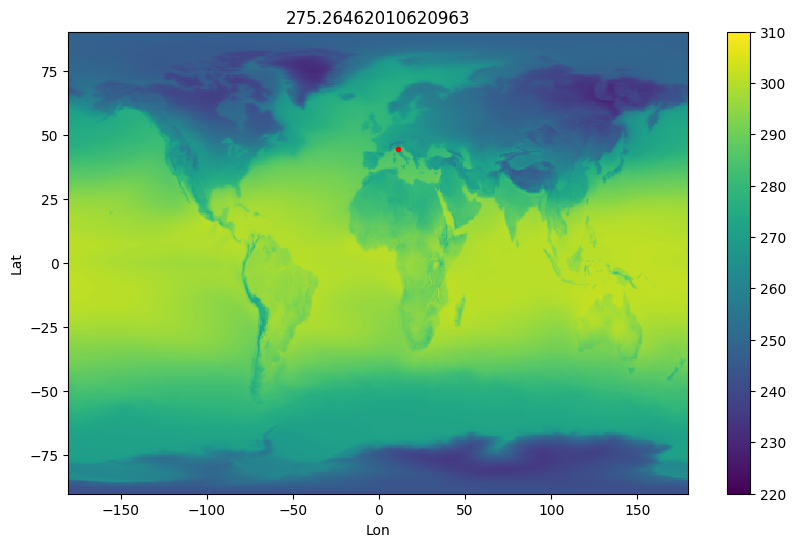

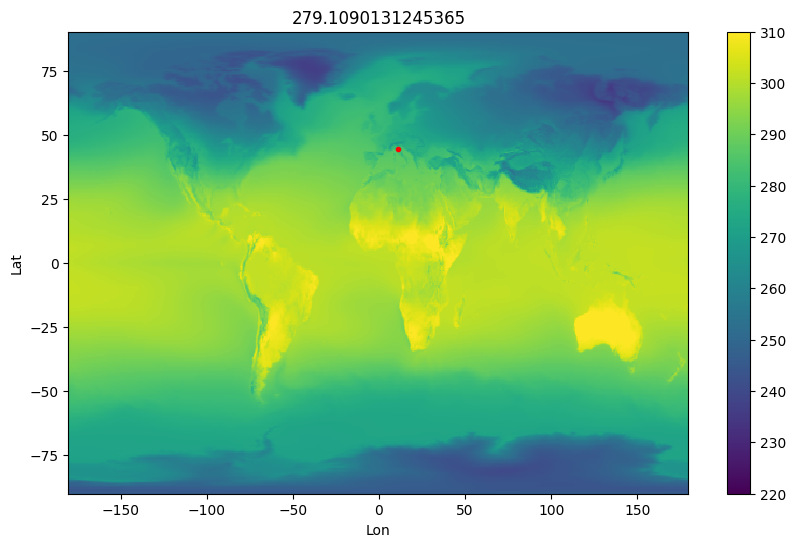

[273.66343043 274.50566798 277.06618475 280.93322678 285.26426018
 290.20805697 293.12705908 292.53044239 288.21384572 283.52300735
 278.39855911 274.6534429 ]
[281.66204347 283.45797469 287.5356749  292.00669337 296.84985923
 302.64894084 306.44260426 305.38960704 299.61742922 293.85967565
 287.12539769 282.59279594]


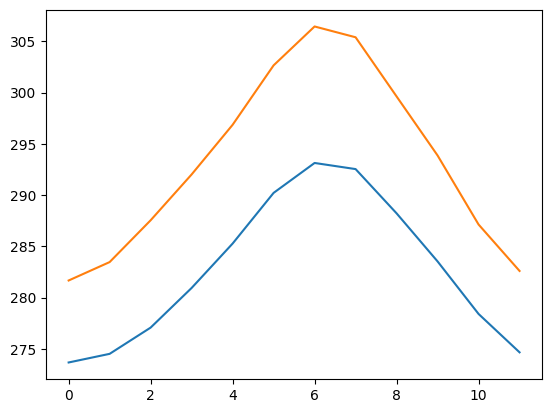

In [14]:
# Check by mapping
import matplotlib.pyplot as plt

row = 269
col = 306
month_sel = 0
# Example lat, lon, and 2D data arrays
ex_file = xr.open_dataset(l_files[0])
lat = ex_file['lat']
lon = ex_file['lon']
print(float(lat[row]), float(lon[col]))
data = Tmin_months[month_sel,:,:]
# Create a meshgrid for lat and lon
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Plotting the 2D array with pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(lon_grid, lat_grid, data, vmin=220, vmax=310, cmap='viridis', shading='auto')
plt.plot(lon[col], lat[row], marker='.', color='r', linestyle="None")
plt.colorbar()
plt.title(str(np.mean(Tmin_months[month_sel,:,:])))

# Adding labels and title
plt.xlabel('Lon')
plt.ylabel('Lat')

# Show the plot
plt.show()

data = Tmax_months[month_sel,:,:]
# Create a meshgrid for lat and lon
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Plotting the 2D array with pcolormesh
plt.figure(figsize=(10, 6))
plt.pcolormesh(lon_grid, lat_grid, data, vmin=220, vmax=310, cmap='viridis', shading='auto')
plt.plot(lon[col], lat[row], marker='.', color='r', linestyle="None")
plt.colorbar()
plt.title(str(np.mean(Tmax_months[month_sel,:,:])))

# Adding labels and title
plt.xlabel('Lon')
plt.ylabel('Lat')

# Show the plot
plt.show()

plt.plot(Tmin_months[:,row,col])
print(Tmin_months[:,row,col])
plt.plot(Tmax_months[:,row,col])
print(Tmax_months[:,row,col])
plt.show()

### Save as netcdf (optional)
The following cell saves the climatologies as netcdf files (***this is not the LIS format***, just for your own usage)

In [7]:
from netCDF4 import Dataset
months = np.arange(1,13)
# save in nc file
nc_out = '/staging/leuven/stg_00024/OUTPUT/louiseb/clim4LIS-AC/MERRA2_tmin_tmax_monthlyclim_' + str(ystart) + '-' + str(yend) + '.nc'
with Dataset(nc_out, 'w', format="NETCDF4") as ds:
    ds.createDimension('month', len(months))
    print('month created')
    ds.createDimension('lat', len(lat))
    print('lat created')
    ds.createDimension('lon', len(lon))
    print('lon created')

    ds.createVariable('month', 'int', dimensions='month', zlib=True)
    ds.createVariable('lat', 'float', dimensions='lat', zlib=True)
    ds.createVariable('lon', 'float', dimensions='lon', zlib=True)
    ds.createVariable('tmin', 'float', dimensions=('month', 'lat', 'lon'), zlib=True)
    ds.variables['tmin'].setncatts({'long_name': 'average minimum 2m air temperature', 'unit': 'Kelvin'})
    ds.createVariable('tmax', 'float', dimensions=('month', 'lat', 'lon'), zlib=True)
    ds.variables['tmax'].setncatts({'long_name': 'average maximum 2m air temperature', 'unit': 'Kelvin'})


    ds.variables['lat'][:] = lat
    ds.variables['lon'][:] = lon
    ds.variables['month'][:] = months
    ds.variables['tmin'][:] = np.round(Tmin_months,4)
    ds.variables['tmax'][:] = np.round(Tmax_months,4)
    
    # Add global attributes (start and end year)
    ds.setncatts({
        'title': 'Monthly climatology of Tmin and Tmax',
        'author': 'Louise Busschaert (KU Leuven)',
        'source': 'MERRA2 2-m files',
        'start_year': ystart,
        'end_year': yend
    })

print('Saved')

month created
lat created
lon created
Saved


### Save in LIS format
This cell saves the climatologies in monthly text files, as read in by LDT.

In [15]:
# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Month names for the file names
month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Set the grid size and parameters
ncols = int(lon.size)
nrows = int(lat.size)
cellxsize = round(float(lon[1]-lon[0]), 3)
cellysize = round(float(lat[1]-lat[0]), 3)
xllcorner = lon[0] + 0.5 * cellxsize
yllcorner = lat[0] + 0.5 * cellysize
NODATA_value = -9999

# Save data to text files
for i, month in enumerate(month_names):
    # Create file names
    tmin_file = os.path.join(output_dir, f'tmin.{month}.txt')
    tmax_file = os.path.join(output_dir, f'tmax.{month}.txt')
    
    # Write tmin data
    with open(tmin_file, 'w') as f:
        f.write(f"ncols {ncols}\n")
        f.write(f"nrows {nrows}\n")
        f.write(f"xllcorner {xllcorner}\n")
        f.write(f"yllcorner {yllcorner}\n")
        f.write(f"cellxsize {cellxsize}\n")
        f.write(f"cellysize {cellysize}\n")
        f.write(f"NODATA_value {NODATA_value}\n")
        
        # Write each column in a new line
        for j in range(nrows):
            f.write(' '.join(f'{Tmin_months[i, j, k]:.4f}' for k in range(ncols)) + '\n')

    # Write tmax data
    with open(tmax_file, 'w') as f:
        f.write(f"ncols {ncols}\n")
        f.write(f"nrows {nrows}\n")
        f.write(f"xllcorner {xllcorner}\n")
        f.write(f"yllcorner {yllcorner}\n")
        f.write(f"cellxsize {cellxsize}\n")
        f.write(f"cellysize {cellysize}\n")
        f.write(f"NODATA_value {NODATA_value}\n")
        
        # Write each column in a new line
        for j in range(nrows):
            f.write(' '.join(f'{Tmax_months[i, j, k]:.4f}' for k in range(ncols)) + '\n')
    
    print(f'Saved: {tmin_file}')
    print(f'Saved: {tmax_file}')

print('All monthly text files have been saved.')

Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmin.jan.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmax.jan.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmin.feb.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmax.feb.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmin.mar.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmax.mar.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmin.apr.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmax.apr.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmin.may.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmax.may.txt
Saved: /staging/leuven/stg_00024/OUTPUT/louiseb/Tclim_LIS-AC/MERRA2_2005-2024/tmin.jun.txt